# Tutorial: Analytic continuation of SrVO$_3$ self-energy

This tutorial covers, in a pedagogical way, a real-world use case of the `ana_cont` library. 
We will show how to read Matsubara data from a w2dynamics output hdf5 file and prepare the data for analytic continuation.
Then, analytic continuation is performed by two different methods: MaxEnt and Pade.
Finally, we can use the Kramers-Kronig relations to get the full complex self-energy, including real and imaginary part on the real-frequency axis. 

First, we need some standard imports: sys, os, numpy, h5py, matplotlib.pyplot. 

Then, we insert the path of the ana_cont repository into the python-path. This allows us to import ana_cont without having to install it. But note that, for using Pade later in the notebook, it is necessary that you have already compiled it (`python setup.py build_ext --inplace`)

In [1]:
import sys, os
import numpy as np
import h5py
import matplotlib.pyplot as plt
sys.path.insert(0, os.environ['HOME'] + '/Programs/ana_cont')
import ana_cont.continuation as cont

First, download the DMFT file [from here](https://github.com/josefkaufmann/ana_cont/wiki/datafiles/dmft_svo.hdf5).

Load DMFT data from w2dynamics output file. It contains a single-shot symmetric improved estimators calculation on top of a converged DMFT calculation of SrVO$_3$ with three degenerate orbitals. The system is paramagnetic.

If you have not saved the DMFT file in the current working directory, you have to add the path to it in the file name in the first line of the following cell. 

In [2]:
f = h5py.File('dmft_svo.hdf5', 'r')
beta = f['.config'].attrs['general.beta']
siw_full = f['stat-001/ineq-001/siw-full/value'][()]
siw_err_full = f['stat-001/ineq-001/siw-full/error'][()]
smom = f['stat-001/ineq-001/smom/value'][()]
siw = np.diagonal(np.diagonal(siw_full, axis1=0, axis2=2), axis1=0, axis2=1).transpose((1, 2, 0))
err = np.diagonal(np.diagonal(siw_err_full, axis1=0, axis2=2), axis1=0, axis2=1).transpose((1, 2, 0))
smom = np.mean(smom, axis=(0, 1))  # degenerate spins and orbitals -> average over 6 components
siw = np.mean(siw, axis=(0, 1))
err = np.mean(err, axis=(0, 1)) / np.sqrt(6.)
niw_full = siw.shape[-1] // 2
f.close()

Now prepare the data for analytic contination, i.e. subtract the Hartree term and select a Matsubara frequency range. We then plot the data to make sure we reach the asymptotic region. We also (logarithmically) plot the QMC error, which does not increase at high frequencies, because we have used symmetric improved estimators.

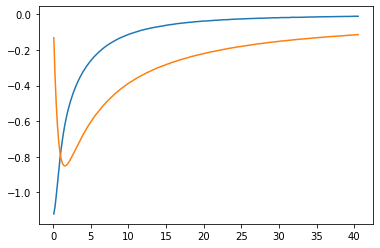

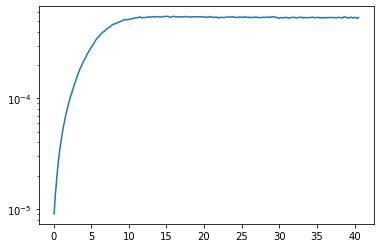

In [3]:
niw = 250
siw_cont = siw[niw_full:niw_full+niw] - smom[0]
err_cont = err[niw_full:niw_full+niw]
iw = np.pi / beta * (2. * np.arange(niw) + 1.)

w = 15. * np.tan(np.linspace(-np.pi / 2.1, np.pi / 2.1, num=1001, endpoint=True)) / np.tan(np.pi / 2.1)
model = np.ones_like(w)
model /= np.trapz(model, w)
model *= -smom[1]
plt.plot(iw, siw_cont.real)
plt.plot(iw, siw_cont.imag)
plt.show()

plt.semilogy(iw, err_cont)
plt.show()

Define the `AnalyticContinuationProblem` for MaxEnt, and solve it. As a reasonable value for the blur width we take 0.16, but feel free to change it and see what happens.

1001 data points on real axis
500 data points on imaginary axis
48 significant singular values
Precomputation of coefficient matrices...
log10(alpha) = 14.00,	chi2 = 3.081e+10,   S = -3.738e-08,   nfev = 7,   norm = 4.661
log10(alpha) = 13.00,	chi2 = 3.068e+10,   S = -3.717e-06,   nfev = 13,   norm = 4.661
log10(alpha) = 12.00,	chi2 = 2.940e+10,   S = -3.521e-04,   nfev = 17,   norm = 4.660
log10(alpha) = 11.00,	chi2 = 2.050e+10,   S = -2.267e-02,   nfev = 20,   norm = 4.670
log10(alpha) = 10.00,	chi2 = 4.430e+09,   S = -3.019e-01,   nfev = 45,   norm = 4.864
log10(alpha) = 9.00,	chi2 = 5.098e+08,   S = -8.163e-01,   nfev = 49,   norm = 5.336
log10(alpha) = 8.00,	chi2 = 3.976e+07,   S = -1.421e+00,   nfev = 58,   norm = 6.039
log10(alpha) = 7.00,	chi2 = 4.827e+06,   S = -1.830e+00,   nfev = 81,   norm = 6.101
log10(alpha) = 6.00,	chi2 = 7.135e+05,   S = -2.431e+00,   nfev = 58,   norm = 5.420
log10(alpha) = 5.00,	chi2 = 6.462e+04,   S = -3.271e+00,   nfev = 101,   norm = 4.917
log10(al

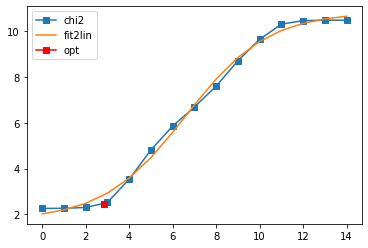

In [4]:
probl_maxent = cont.AnalyticContinuationProblem(im_axis=iw, re_axis=w, im_data=siw_cont,
                                        kernel_mode='freq_fermionic', beta=beta)
sol_maxent = probl_maxent.solve(method='maxent_svd', optimizer='newton', alpha_determination='chi2kink',
                              model=model, stdev=err_cont, 
                              preblur=True, blur_width=0.16,
                              alpha_start=1e14, alpha_end=1e0, alpha_div=10., fit_position=2.,
                              interactive=True)

Now we can plot the resulting spectral function. Here it is extremely important to look also at the backtransform (middle panel) and the difference of data and backtransform (right panel). The range between the error bars is shaded. 

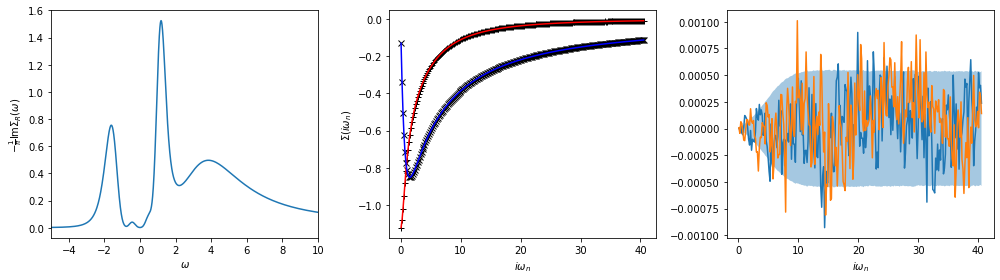

In [5]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4))
ax[0].plot(w, sol_maxent[0].A_opt)
ax[0].set_xlim(-5, 10)
ax[0].set_xlabel(r'$\omega$')
ax[0].set_ylabel(r'$-\frac{1}{\pi} \mathrm{Im} \Sigma_R(\omega)$')
ax[1].plot(iw, siw_cont.real, ls='None', marker='+', color='black')
ax[1].plot(iw, siw_cont.imag, ls='None', marker='x', color='black')
ax[1].plot(iw, sol_maxent[0].backtransform.real, color='red')
ax[1].plot(iw, sol_maxent[0].backtransform.imag, color='blue')
ax[1].set_xlabel(r'$i\omega_n$')
ax[1].set_ylabel(r'$\Sigma(i\omega_n)$')
ax[2].plot(iw, (siw_cont - sol_maxent[0].backtransform).real)
ax[2].plot(iw, (siw_cont - sol_maxent[0].backtransform).imag)
ax[2].fill_between(iw, -err_cont, err_cont, alpha=0.4)
ax[2].set_xlabel(r'$i\omega_n$')
plt.tight_layout()
plt.show()

Perform the analytic continuation by Pade. The selected `indices_pade` represent a reasonable choice, but are by no means unique. Feel free to experiment with their number and spacing. Keep in mind, however, that the calculation time steeply increases when using more than approximately 25 data points on the imaginary axis.

We plot the imaginary-axis data that were used for the calculation of the Pade coefficients. Also, we plot the Pade-interpolation on a fine grid on the imaginary axis. If there are pole-zero pairs along the imaginary axis as a consequence of noise, these are usually visible in such a plot. It may then be indicated to choose a different set of Matsubara frequencies, or get better data.

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 20 28 36 44 52 60 68 76 84 92] (23,)


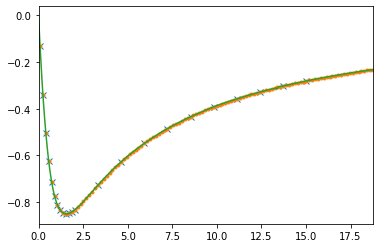

In [6]:
indices_pade = np.concatenate((np.arange(12), np.arange(12, 100, 8)))
print(indices_pade, indices_pade.shape)
iw_pade = iw[indices_pade]
siw_pade = siw_cont[indices_pade]
w_pade = np.linspace(-5., 10., num=401)
probl_pade = cont.AnalyticContinuationProblem(im_axis=iw_pade,
                                              re_axis=w_pade,
                                              im_data=siw_pade,
                                              kernel_mode='freq_fermionic')
sol_pade = probl_pade.solve(method='pade')
check_axis = np.linspace(0., 1.25 * iw_pade[-1], num=500)
check = probl_pade.solver.check(im_axis_fine=check_axis)
plt.plot(iw_pade, siw_pade.imag, ls='None', marker='x')
plt.plot(iw, siw_cont.imag, ls='None', marker='.')
plt.plot(check_axis, check.imag)
plt.xlim(0., check_axis[-1])
plt.show()

Plot both spectral function on the full frequency range and in the low-frequency region.

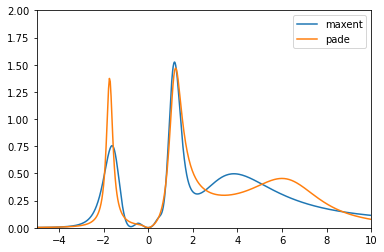

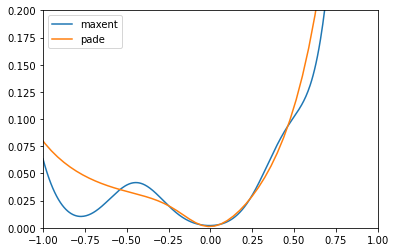

In [7]:
plt.plot(w, sol_maxent[0].A_opt, label='maxent')
plt.plot(w_pade, sol_pade.A_opt, label='pade')
plt.xlim(-5., 10.)
plt.ylim(0., 2.)
plt.legend()
plt.show()

plt.plot(w, sol_maxent[0].A_opt, label='maxent')
plt.plot(w_pade, sol_pade.A_opt, label='pade')
plt.xlim(-1., 1.)
plt.ylim(0., 0.2)
plt.legend()
plt.show()

Just out of curiosity, also look at the QMC error (logplot!) at the points that were used for the Pade interpolation.

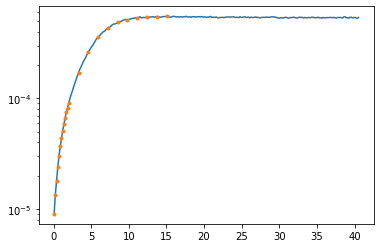

In [8]:
plt.semilogy(iw, err_cont)
plt.semilogy(iw_pade, err_cont[indices_pade], linestyle='None', marker='.')
plt.show()